In [1]:
# set tf 1.x for colab
#%tensorflow_version 1.x

# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 2.4.0


# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [3]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


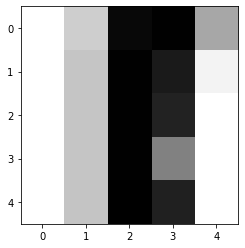

And the whole sample:


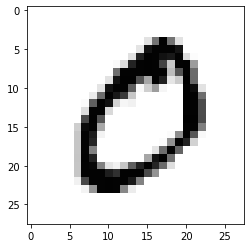

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [4]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [5]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [6]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [7]:
W = tf.Variable(tf.random.normal(shape=(784,10)), name="W")
b = tf.Variable(tf.zeros(shape=10), name = 'b')

In [8]:
def logits(X):
    X = tf. cast(X, tf.float32)
    logits = tf.matmul(X,W) + b
    return logits

In [9]:
def classes(X):
    probas = tf.nn.softmax(logits(X))
    classes = tf.argmax(probas, 1)
    return classes

In [10]:
def compute_loss(X, Y):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = X)
    loss = tf.reduce_mean(cross_entropy)
    return loss

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

In [12]:
BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        
        input_X = X_train_flat[batch_start:batch_start+BATCH_SIZE]
        input_Y = y_train_oh[batch_start:batch_start+BATCH_SIZE]
                
        with tf.GradientTape() as tape:
            logit = logits(input_X)
            loss = compute_loss(logit, input_Y)           
            
        gradients = tape.gradient(loss, [W,b])
    
        optimizer.apply_gradients(zip(gradients, [W,b]))
    
        batch_losses.append(loss)
   

    train_loss = np.mean(batch_losses)
    val_loss = compute_loss(logits(X_val_flat), y_val_oh)
    train_accuracy = accuracy_score(y_train, classes(X_train_flat))
    valid_accuracy = accuracy_score(y_val, classes(X_val_flat))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuN%2BOP7QHwm/Zx8JW/jT4veJ5dPtL7U4dN0u2stLub%2B91K9lDGO1tLO0jluLudlR2EUMbvtR2xhWI7KvFv2u/gP8VPiX4h%2BGfxl%2BBd14fl8X/CrxjPrWmaJ4tu57bTdYhudLvdMubaW4ghmktH8q9aSOdYZtrR7TGyu2ACjpH/AAUr/Y71rxmfh5bePfEEGtwaVDqmradqPw5160k0WxkNwFu9S8%2ByQaZADazhpbswohTDFSygzeE/%2BCj/AOxr4z8H%2BIfHWmfFi5tdP8MaPa6vqg1zwnqumXEmn3LmO1vLW3u7WKa%2Bt55AY4ZbZJUmchIyzEA%2Bd3n7DHxn%2BOtp%2B0i37Qt74V8MS/tB/CPTvB0kfgrWLrUzo7RWusWsr%2BbcWtqZ1VNRiZDsXeyygogxuytY/Y2/at%2BM%2Btaz8UP2lPh38G9X1e0%2BE6eBtB8E6d4n1QaRrSy6jaXt5fXd2bBJ9PYmyg%2BzxQw3BtnDP50hIwAeyX/7fP7N2leAbH4h6tdeOLSHVPED6Jpeh3Xwj8SR67e3yW5uXjh0dtPGoSqsAMpkS3KBFZi2Acen%2BEvHXhvxr4JsfiHotxcxaVqFgt5BLqmnz2MscJXdmWG5SOWBgPvJIqspBDAEEV8a237DP7WkvwUk8LePvC/hTxpfQ/EOXW/Beg6z%2B0P4rt7vwHYnTYrURaf4tj09tWuJDKLuVvMhjAjvDCG2RjPqfg/9gzVfFPwF0bwt%2B038dfHHiPx8nw2uvC2v%2BIdJ%2BIetW%2BmXQubW5t5Jn0tbpLG8mRLpgt1cWzTO0UUrFXRNgBt%2BGP8AgpJ%2Bxl4v8PeJPFmjfFq5XTPC3gy88XX99feEtVtIr3QLVd1xqmntPaoNVtEBXM9l56EyRgEmRA3E/Gj/AIK6fsw%2BA/2Z/ib%2B0D8K31nxnd/DfwbD4kbwy3hfWNNm1exuHaO1u7V5rAtcWMsiMPt8Ec1siqzs4VSR474X/wCCUPxoX4J%2BL/hZ4s8O%2BHpPEP8AwoXxH4B8F%2BPNR/aH8beIEkuNSsI7TzDpGqpJbaNbSGGJ5Y4JLpk8qNULBBn0f9qX/gnN8UP2gLDxVomh%2BMfDulW2vfsr33w0tZZnnYwatJcRywztGsQBtRsIJDeYM8J3oA9Ul/4KKfss2/ibw14EvNX8a23iTxdp0uoaD4UvPhJ4lh1eWziu/sclzJYSaeLm3hSYjdJNGiKjLKSI2VzL4G/4KJ/sd/EjVNV0rwh8W5JzpWiahrK3c/hrUre01TT7Fgl5d6bczW6Q6rDCxUO9k86qXUE/MM4vgj4AfHnxj%2B1TY/tQfHPw/wCDvD8knwcv/B%2BqaJ4T8V3eqmC5l1aO5SSG5n0%2BzLxNBEpYmNGSQ7QrqokPgM37Dn7S/wANv2efC/hT40a14EHhH9m74H%2BJNA8F6n4VvruTUvFO7QjplvcXtvLbRRacEs0ZpIYpboSTsrh41QKQD6B8Kf8ABUv9hfxp4N1n4haH8ZbtdF0LwcfFt1qN/wCDNYs47nQQUD6rZ%2BfaIb%2BzjMiCSe2EscW4eYy5r121%2BMHw5vfi5cfAqz8RibxVZ%2BGoNfu9MitZWEOnTzy28M7yhPKXzJYJ1RC%2B9vJkIUhGI%2BKv2R/2fviF4s%2BCXwh%2BO37b%2BpfDLRfhh8N/2X7nw/BJp2tzhNX03VNO0s3l9qv2qCGHTIIrTTlVoEluEzK8jTKsarXYf8EVvhX470f9nfU/j18VvFreItY8a30Gm%2BHPEMsDRyX3hHRIv7K0S4Ifn/SoYZtUJ7vqzkBQQoAPsqiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvEdI/4KMfse6ld69Z6n8Urzw83hzw5c%2BINQk8a%2BEdV0GObSbd0jnv7WTUrWBb63R5IlaW2MqAyxjOXXPtN7FczWcsNndCCZ4mWKYx7/LYjhtp64POO9fmJq/8AwRy/bl%2BL%2BreF9c%2BN3xx0N9b8NeD9Qs9Q8Uah8VvE3iceIdb%2B2aVfWuonS76KGy0m2kudMXz7CyAURybVlkCoFAPtl/2//wBmG1%2BGjfFjWPEHirStLbXINGsbPXPhlr9hqmp38yGSGCy024sUvb9pEDOv2eGQMqOwJCMR0XgP9qz4H/EfX7Lwn4c8Q6pDq9/4Un8SQ6RrXhXUtMu002G7%2BySyyw3lvFJA6z/IYZFWXvs2815N8Tvg5%2B278Ym%2BHvxt1zwb8KtD%2BIfwo8dTax4f8M2vjjUr/Rdcs7jSbvTLmO4vn0qGaxmKXskkbpa3AjMQU%2BYJGxV%2BJPwG/bg1/wCMvh39prwPo3wrtPFl98MNV8F%2BMdC1LxXqUlhpC3F/DdWt/ZXCacJNQMQjdZLeWK0EpcYlixyAdxpP/BRv9kDxHr3gXwt4V%2BI2q6zqfxJ8G6V4t8G6dongfWb2e80PUX2WuoyJBaM1rb7seZJOI1twymbygwJ2Phr%2B25%2Bzd8V/iNc/Cfwz4v1az1%2B30u51OGy8T%2BDNW0Rb%2Bxt5Ejnu7KXUbWCO/gjeWIPLbNIi%2BYhJAZSfKP2FP2Evix%2BzDr/w41nx54g8NXZ8HfspeEfhjfvpFzPKzatpbzNczReZBHutW3psZirtt%2BaNMCvGvhp/wSr/AGxvE/xR8L%2BJv2pvjDZ6pFp/gDxX4X8aeJoPi/4k1q88RS6vYpbf2na6ZfQx6foRypY2lopRcqBM4jVaAPqXwn/wUX/ZH8a6LH4q0Hx3rn9h3Gq6Xp%2Bn%2BJb34f63a6VqMupXsdlZSWl9PZpbXkEtzNFGLiCR4QZULOFYE%2Bl%2BFvi78PPGvxA8U/C7wv4h%2B1654Lks4/E9olpMFsZLqD7RBGZWQRu7QlZCiMzIskZYKJE3fMPjjwJ8RfCv/BPbxp8CP%2BChnif4VeCPAWg/DSLQLb4meHfFt2GadI0trXUntLqzgTTZlmFvJDBHcXTGcoiOTtDdr/wSv%2BH3xY8N/siaV8Vf2irBLf4nfFi%2Bl8dfESFLdovs9/frGYbTY3zJ9lsY7Kz2nJAtcGgD6NooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiig